In [164]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Generating Raw data for training the PINN

In [165]:
g = 9.81
h0 = 1.0
v0 = 10.0

def true_solution(t):
    return h0 + v0 * t - 0.5 * g *(t**2)

t_min, t_max = 0.0, 2.0
N_data = 10
t_data = np.linspace(t_min, t_max, N_data)

np.random.seed(0)
noise_level = 0.7
h_data_exact = true_solution(t_data)
h_data_noisy = h_data_exact + noise_level * np.random.randn(N_data)

t_data_tensor = tf.convert_to_tensor(t_data, dtype = tf.float32)
h_data_tensor = tf.convert_to_tensor(h_data_noisy, dtype = tf.float32)

# Plotting the Synthetic/Raw Data

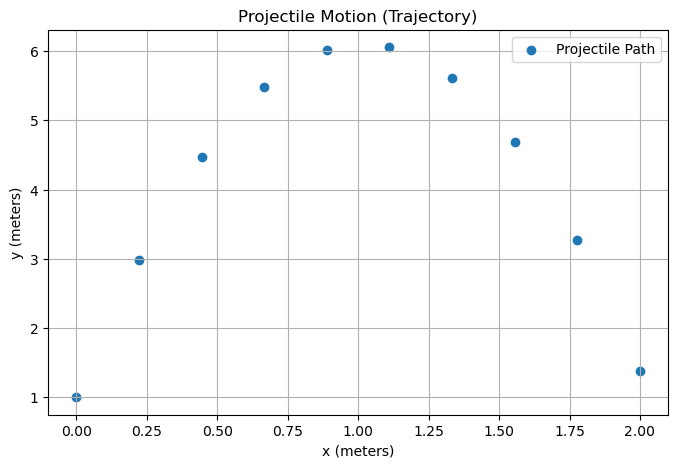

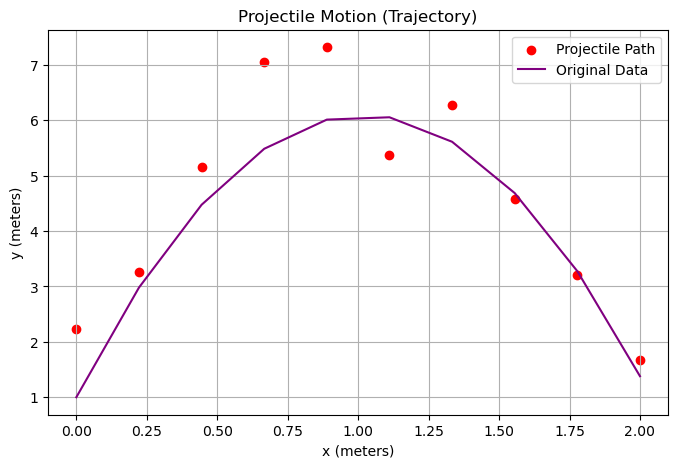

In [166]:
plt.figure(figsize=(8, 5))
plt.scatter(t_data, h_data_exact, label="Projectile Path")
plt.title("Projectile Motion (Trajectory)")
plt.xlabel("x (meters)")
plt.ylabel("y (meters)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(t_data, h_data_noisy, label="Projectile Path", color = 'red')
plt.plot(t_data, h_data_exact, color = "purple", label = "Original Data")
# for xn, yn, xr, yr in zip(x_noisy, y_noisy, x_real, y_real):
#     plt.plot([xn, xr], [yn, yr], color = "skyblue", linestyle = '-', linewidth = 0.8)
plt.title("Projectile Motion (Trajectory)")
plt.xlabel("x (meters)")
plt.ylabel("y (meters)")
plt.grid(True)
plt.legend()
plt.show()

# Creating the Neural Network

In [167]:
model = tf.keras.Sequential([
    layers.Input(shape = (1, )),
    layers.Dense(64, activation = "tanh"),
    layers.Dense(64, activation = "tanh"),
    layers.Dense(1)
])

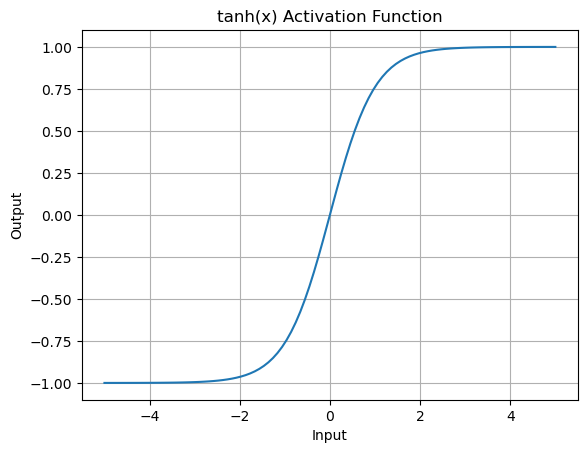

In [168]:
x = np.linspace(-5, 5, 100)
y = np.tanh(x)

plt.plot(x, y, label = "tanh(x)")
plt.xlabel("Input")
plt.ylabel("Output")
plt.title("tanh(x) Activation Function")
plt.grid(True)
plt.show()

In [169]:
def derivative_function(y, x):
    with tape.GradientTape() as tape:
        tape.watch(x)
        y_pred = y
    dy_dx = tape.gradient(y_pred, x)
    return dy_dx

In [170]:
def physics_loss(model, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        h_pred = model(t)
    dh_dt_pred = tape.gradient(h_pred, t)

    dh_dt_true = v0 - g * t
    return tf.reduce_mean((dh_dt_pred - dh_dt_true) ** 2)

def initial_loss(model, t):
    t0 = tf.constant([[0.0]], dtype = tf.float32)
    h0_pred = model(t0)
    return tf.reduce_mean((h0_pred - h0) ** 2)

def data_loss(model, t_data, h_data):
    h_pred = model(t_data)
    return tf.reduce_mean((h_pred - h_data) ** 2)

In [171]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

lambda_data = 2
lambda_ode = 2
lambda_ic = 2

epochs = 4000
print_every = 200

In [172]:
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss_data = data_loss(model, t_data_tensor, h_data_tensor)
        loss_initial = initial_loss(model, t_data_tensor)
        loss_ode = physics_loss(model, t_data_tensor)

        total_loss = lambda_data * loss_data + lambda_ic * loss_initial + lambda_ode * loss_ode
        
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if (epoch + 1) % print_every == 0:
        print(f"Epoch {epoch + 1}/{epochs}", f"Total Loss: {total_loss.numpy():.6f}", f"ODE Loss: {loss_ode.numpy():.6f}", f"Data Loss: {loss_data.numpy():.6f}", f"Initial Loss: {loss_initial.numpy():.6f}")

Epoch 200/4000 Total Loss: 29.975424 ODE Loss: 9.528639 Data Loss: 5.296546 Initial Loss: 0.162527
Epoch 400/4000 Total Loss: 17.654045 ODE Loss: 2.438653 Data Loss: 6.218453 Initial Loss: 0.169916
Epoch 600/4000 Total Loss: 13.117338 ODE Loss: 0.223972 Data Loss: 6.259617 Initial Loss: 0.075081
Epoch 800/4000 Total Loss: 13.083914 ODE Loss: 0.211338 Data Loss: 6.255214 Initial Loss: 0.075405
Epoch 1000/4000 Total Loss: 13.069718 ODE Loss: 0.204600 Data Loss: 6.254543 Initial Loss: 0.075717
Epoch 1200/4000 Total Loss: 13.061822 ODE Loss: 0.202532 Data Loss: 6.252446 Initial Loss: 0.075933
Epoch 1400/4000 Total Loss: 13.057732 ODE Loss: 0.202167 Data Loss: 6.250720 Initial Loss: 0.075979
Epoch 1600/4000 Total Loss: 13.054810 ODE Loss: 0.202103 Data Loss: 6.249408 Initial Loss: 0.075894
Epoch 1800/4000 Total Loss: 13.052113 ODE Loss: 0.202082 Data Loss: 6.248204 Initial Loss: 0.075770
Epoch 2000/4000 Total Loss: 13.049242 ODE Loss: 0.201935 Data Loss: 6.247037 Initial Loss: 0.075649
Epoc

In [175]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

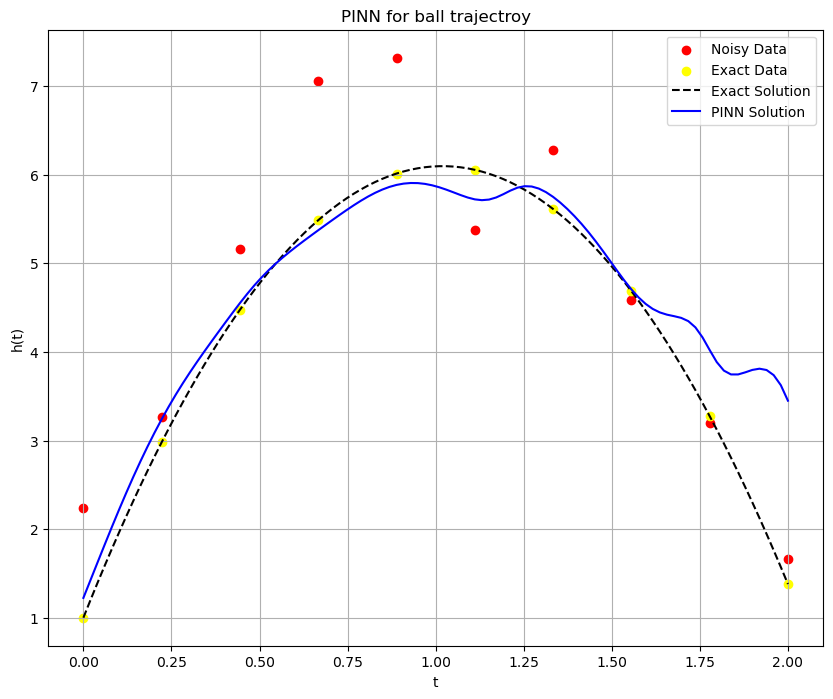

In [182]:
t_plot = np.linspace(t_min, t_max, 100).reshape(-1, 1).astype(np.float32)
t_plot_tensor = tf.convert_to_tensor(t_plot)

h_pred_plot = model(t_plot_tensor).numpy()

h_true_plot = true_solution(t_plot)

plt.figure(figsize = (10, 8))
plt.scatter(t_data, h_data_noisy, color = "red", label = "Noisy Data")
plt.scatter(t_data, h_data_exact, color = "yellow", label = "Exact Data")
plt.plot(t_plot, h_true_plot, 'k--', label = "Exact Solution")
plt.plot(t_plot, h_pred_plot, 'b', label = "PINN Solution")
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title("PINN for ball trajectroy")
plt.grid(True)
plt.show()